In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    channel_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())        
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_8 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_9 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_17 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 32)         3104      
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1709 - acc: 0.3524
Epoch 00001: val_loss improved from inf to 2.12355, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_4_conv_checkpoint/001-2.1235.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.1707 - acc: 0.3525 - val_loss: 2.1235 - val_acc: 0.3778
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4838 - acc: 0.5350
Epoch 00002: val_loss improved from 2.12355 to 1.28673, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_4_conv_checkpoint/002-1.2867.hdf5
36805/36805 [==============================] - 76s 2ms/sample - loss: 1.4838 - acc: 0.5350 - val_loss: 1.2867 - val_acc: 0.6021
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2601 - acc: 0.6050
Epoch 00003: val_loss improve

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2030 - acc: 0.9423
Epoch 00028: val_loss did not improve from 1.15976
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.2030 - acc: 0.9423 - val_loss: 1.3931 - val_acc: 0.6548
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1921 - acc: 0.9460
Epoch 00029: val_loss did not improve from 1.15976
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.1921 - acc: 0.9460 - val_loss: 1.4802 - val_acc: 0.6541
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1854 - acc: 0.9479
Epoch 00030: val_loss did not improve from 1.15976
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.1854 - acc: 0.9479 - val_loss: 1.3770 - val_acc: 0.6634
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1825 - acc: 0.9490
Epoch 00031: val_loss did not improve from 1.15976
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1016 - acc: 0.9732
Epoch 00058: val_loss did not improve from 1.15976
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.1016 - acc: 0.9732 - val_loss: 1.6869 - val_acc: 0.6615

1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_4_conv Model


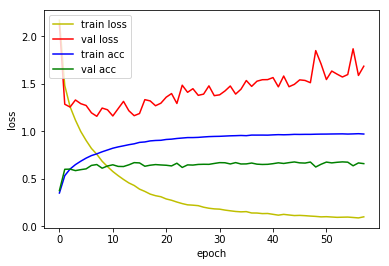

4815/4815 [==============================] - 4s 793us/sample - loss: 1.3146 - acc: 0.6035
Loss: 1.3145651748494815 Accuracy: 0.60353065

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0506 - acc: 0.3770
Epoch 00001: val_loss improved from inf to 2.78989, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_5_conv_checkpoint/001-2.7899.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 2.0506 - acc: 0.3770 - val_loss: 2.7899 - val_acc: 0.2457
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4128 - acc: 0.5626
Epoch 00002: val_loss improved from 2.78989 to 1.26553, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_5_conv_checkpoint/002-1.2655.hdf5
36805/36805 [==============================] - 79s 2ms/sample - loss: 1.4128 - acc: 0.5626 - val_loss: 1.2655 - val_acc: 0.6042
Epoch 3/500
36800/36805 [===========

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2362 - acc: 0.9321
Epoch 00028: val_loss did not improve from 0.98452
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.2363 - acc: 0.9321 - val_loss: 1.1474 - val_acc: 0.7042
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2360 - acc: 0.9305
Epoch 00029: val_loss did not improve from 0.98452
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.2360 - acc: 0.9305 - val_loss: 1.1574 - val_acc: 0.7023
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2205 - acc: 0.9355
Epoch 00030: val_loss did not improve from 0.98452
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.2205 - acc: 0.9355 - val_loss: 1.1820 - val_acc: 0.7002
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2030 - acc: 0.9406
Epoch 00031: val_loss did not improve from 0.98452
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1114 - acc: 0.9688
Epoch 00058: val_loss did not improve from 0.98452
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1114 - acc: 0.9688 - val_loss: 1.2667 - val_acc: 0.7251
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1034 - acc: 0.9707
Epoch 00059: val_loss did not improve from 0.98452
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1034 - acc: 0.9707 - val_loss: 1.2899 - val_acc: 0.7174
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1014 - acc: 0.9716
Epoch 00060: val_loss did not improve from 0.98452
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1014 - acc: 0.9716 - val_loss: 1.2581 - val_acc: 0.7258
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9737
Epoch 00061: val_loss did not improve from 0.98452
36805/36805 [===========

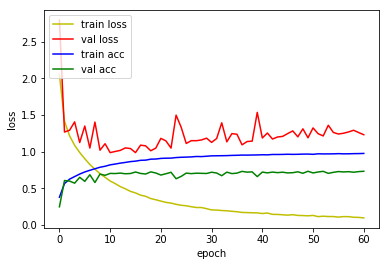

4815/4815 [==============================] - 4s 886us/sample - loss: 1.0661 - acc: 0.6673
Loss: 1.0661346805058536 Accuracy: 0.66728973

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1525 - acc: 0.3417
Epoch 00001: val_loss improved from inf to 2.05860, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_6_conv_checkpoint/001-2.0586.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 2.1526 - acc: 0.3417 - val_loss: 2.0586 - val_acc: 0.3748
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4399 - acc: 0.5455
Epoch 00002: val_loss improved from 2.05860 to 1.18356, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_6_conv_checkpoint/002-1.1836.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.4399 - acc: 0.5455 - val_loss: 1.1836 - val_acc: 0.6219
Epoch 3/500
36800/36805 [==========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2526 - acc: 0.9203
Epoch 00057: val_loss did not improve from 0.82501
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2527 - acc: 0.9203 - val_loss: 0.9857 - val_acc: 0.7552
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2482 - acc: 0.9221
Epoch 00058: val_loss did not improve from 0.82501
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2483 - acc: 0.9221 - val_loss: 0.8922 - val_acc: 0.7605
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2390 - acc: 0.9250
Epoch 00059: val_loss did not improve from 0.82501
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2392 - acc: 0.9250 - val_loss: 1.0091 - val_acc: 0.7347
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2415 - acc: 0.9231
Epoch 00060: val_loss did not improve from 0.82501
36805/36805 [===========

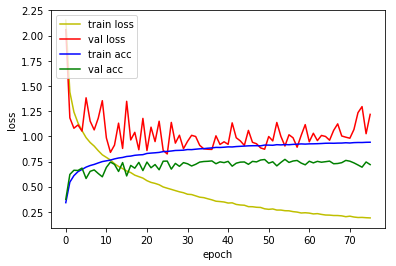

4815/4815 [==============================] - 4s 932us/sample - loss: 0.9156 - acc: 0.7252
Loss: 0.9155668600573594 Accuracy: 0.7252337

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2482 - acc: 0.3161
Epoch 00001: val_loss improved from inf to 2.16457, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_7_conv_checkpoint/001-2.1646.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 2.2481 - acc: 0.3162 - val_loss: 2.1646 - val_acc: 0.2884
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5325 - acc: 0.5106
Epoch 00002: val_loss improved from 2.16457 to 1.34750, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_7_conv_checkpoint/002-1.3475.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.5324 - acc: 0.5106 - val_loss: 1.3475 - val_acc: 0.5686
Epoch 3/500
36800/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.5423 - acc: 0.8346
Epoch 00025: val_loss did not improve from 0.64859
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.5423 - acc: 0.8346 - val_loss: 0.6829 - val_acc: 0.8060
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5242 - acc: 0.8398
Epoch 00026: val_loss did not improve from 0.64859
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.5243 - acc: 0.8398 - val_loss: 0.6781 - val_acc: 0.8099
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5151 - acc: 0.8441
Epoch 00027: val_loss did not improve from 0.64859
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.5151 - acc: 0.8441 - val_loss: 0.6916 - val_acc: 0.7927
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5036 - acc: 0.8502
Epoch 00028: val_loss did not improve from 0.64859
36805/36805 [========================

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3141 - acc: 0.9029
Epoch 00052: val_loss did not improve from 0.58386
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.3141 - acc: 0.9029 - val_loss: 0.5993 - val_acc: 0.8323
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3044 - acc: 0.9054
Epoch 00053: val_loss did not improve from 0.58386
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.3044 - acc: 0.9054 - val_loss: 0.6097 - val_acc: 0.8328
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2998 - acc: 0.9065
Epoch 00054: val_loss did not improve from 0.58386
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2998 - acc: 0.9066 - val_loss: 0.5926 - val_acc: 0.8386
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2945 - acc: 0.9097
Epoch 00055: val_loss did not improve from 0.58386
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2095 - acc: 0.9336
Epoch 00082: val_loss did not improve from 0.58386
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2095 - acc: 0.9336 - val_loss: 0.8058 - val_acc: 0.7939
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1915 - acc: 0.9394
Epoch 00083: val_loss did not improve from 0.58386
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.1918 - acc: 0.9394 - val_loss: 0.6646 - val_acc: 0.8262
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1937 - acc: 0.9379
Epoch 00084: val_loss did not improve from 0.58386
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.1937 - acc: 0.9379 - val_loss: 0.6926 - val_acc: 0.8341
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1859 - acc: 0.9402
Epoch 00085: val_loss did not improve from 0.58386
36805/36805 [===========

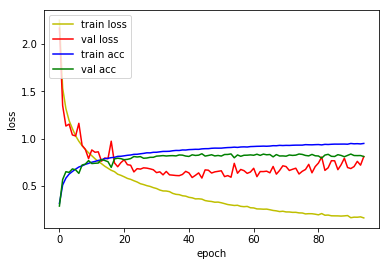

4815/4815 [==============================] - 5s 948us/sample - loss: 0.6809 - acc: 0.8023
Loss: 0.680887314104712 Accuracy: 0.80228454

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2827 - acc: 0.2970
Epoch 00001: val_loss improved from inf to 1.78018, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_8_conv_checkpoint/001-1.7802.hdf5
36805/36805 [==============================] - 121s 3ms/sample - loss: 2.2826 - acc: 0.2971 - val_loss: 1.7802 - val_acc: 0.4952
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5425 - acc: 0.5106
Epoch 00002: val_loss improved from 1.78018 to 1.14806, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_8_conv_checkpoint/002-1.1481.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.5426 - acc: 0.5106 - val_loss: 1.1481 - val_acc: 0.6543
Epoch 3/500
36800/36805 [===========

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2995 - acc: 0.9087
Epoch 00023: val_loss did not improve from 0.33229
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2994 - acc: 0.9087 - val_loss: 0.3326 - val_acc: 0.9029
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2832 - acc: 0.9149
Epoch 00024: val_loss improved from 0.33229 to 0.29551, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_8_conv_checkpoint/024-0.2955.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2834 - acc: 0.9149 - val_loss: 0.2955 - val_acc: 0.9140
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2820 - acc: 0.9153
Epoch 00025: val_loss did not improve from 0.29551
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2821 - acc: 0.9153 - val_loss: 0.3478 - val_acc: 0.9038
Epoch 26/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.1373 - acc: 0.9563
Epoch 00051: val_loss did not improve from 0.27241
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1373 - acc: 0.9563 - val_loss: 0.3081 - val_acc: 0.9159
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1288 - acc: 0.9590
Epoch 00052: val_loss did not improve from 0.27241
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1288 - acc: 0.9590 - val_loss: 0.3186 - val_acc: 0.9126
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1205 - acc: 0.9630
Epoch 00053: val_loss did not improve from 0.27241
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1205 - acc: 0.9630 - val_loss: 0.3423 - val_acc: 0.9064
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1240 - acc: 0.9604
Epoch 00054: val_loss did not improve from 0.27241
36805/36805 [========================

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0704 - acc: 0.9764
Epoch 00081: val_loss did not improve from 0.27241
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0704 - acc: 0.9763 - val_loss: 0.3901 - val_acc: 0.9103
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9726
Epoch 00082: val_loss did not improve from 0.27241
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0842 - acc: 0.9726 - val_loss: 0.3327 - val_acc: 0.9178
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0788 - acc: 0.9749
Epoch 00083: val_loss did not improve from 0.27241
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0788 - acc: 0.9749 - val_loss: 0.3504 - val_acc: 0.9108
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0638 - acc: 0.9802
Epoch 00084: val_loss did not improve from 0.27241
36805/36805 [===========

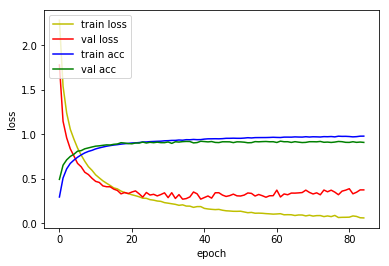

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3279 - acc: 0.9059
Loss: 0.3278949049650571 Accuracy: 0.905919

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8089 - acc: 0.4463
Epoch 00001: val_loss improved from inf to 1.48522, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_9_conv_checkpoint/001-1.4852.hdf5
36805/36805 [==============================] - 136s 4ms/sample - loss: 1.8087 - acc: 0.4464 - val_loss: 1.4852 - val_acc: 0.5211
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0239 - acc: 0.6821
Epoch 00002: val_loss improved from 1.48522 to 0.66852, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_9_conv_checkpoint/002-0.6685.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.0241 - acc: 0.6820 - val_loss: 0.6685 - val_acc: 0.8025
Epoch 3/500
36800/36805 [==============

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9896
Epoch 00053: val_loss did not improve from 0.17132
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0363 - acc: 0.9896 - val_loss: 0.2130 - val_acc: 0.9436
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9889
Epoch 00054: val_loss did not improve from 0.17132
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0373 - acc: 0.9889 - val_loss: 0.2262 - val_acc: 0.9425
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9872
Epoch 00055: val_loss did not improve from 0.17132
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0414 - acc: 0.9872 - val_loss: 0.2308 - val_acc: 0.9436
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9886
Epoch 00056: val_loss did not improve from 0.17132
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9934
Epoch 00083: val_loss did not improve from 0.17132
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0218 - acc: 0.9934 - val_loss: 0.2661 - val_acc: 0.9422
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9944
Epoch 00084: val_loss did not improve from 0.17132
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0198 - acc: 0.9944 - val_loss: 0.2360 - val_acc: 0.9471

1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_9_conv Model


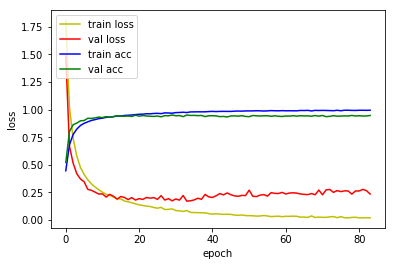

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2432 - acc: 0.9356
Loss: 0.243172841066512 Accuracy: 0.93561786



In [10]:
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN'

for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_4_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 32) 

4815/4815 [==============================] - 4s 820us/sample - loss: 1.0661 - acc: 0.6673
Loss: 1.0661346805058536 Accuracy: 0.66728973

1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_108 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_108 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_22 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_109 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_23 

4815/4815 [==============================] - 4s 897us/sample - loss: 0.6809 - acc: 0.8023
Loss: 0.680887314104712 Accuracy: 0.80228454

1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_134 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_134 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_26 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_135 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_27 (

4815/4815 [==============================] - 5s 939us/sample - loss: 0.2432 - acc: 0.9356
Loss: 0.243172841066512 Accuracy: 0.93561786


In [9]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_92 (Conv1D)

4815/4815 [==============================] - 5s 982us/sample - loss: 1.3471 - acc: 0.6687
Loss: 1.3471461690970052 Accuracy: 0.6687435

1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_120 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_24 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_121 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_25 (

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4469 - acc: 0.8926
Loss: 0.44691954959466323 Accuracy: 0.8926272

1D_CNN_custom_conv_3_VGG_ch_32_DO_025_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_150 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_151 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_29 (A